# Operator Inference Example for 1D-Heat Equation

## Heat Equation 

The heat equation is a fundamental partial differential equation that describes the diffusion of heat in a given medium over time. It is used to model how temperature changes spread through materials, such as solids, liquids, and gases. The equation is given by:

$$
u_t = \mu u_{xx}
$$

where 

$$
\begin{align}
u_t &= \frac{\partial u(t,x)}{\partial t} \\
u_{xx} &= \frac{\partial^2 u(t,x)}{\partial x^2}
\end{align}
$$

and $\mu$ is the thermal diffusivity parameter. In order to discretize this equation in terms of the spatial domain to obtain multiple ODEs that we can numerically integrate we use the finite difference approach. Let $k = \{1,2,3,\ldots,K\} \in \mathbb{Z}^+$ and $j = \{1,2,3,\ldots,J\}\in\mathbb{Z}^+$. Then let $u^k_j$ indicate the state $u$ at the $k$-th discrete time and $j$-th discrete spatial point. With this discrete expression we can express $u_t$ and $u_{xx}$ as follows.

$$
\begin{align}
u_t &= \frac{\partial u(t_k,x_j)}{\partial t} = \frac{u^{k+1}_j - u^k_j}{\Delta t} + \mathcal{O}(\Delta t) \\
u_{xx} &= \frac{\partial^2 u(t_k,x_j)}{\partial x^2} = \frac{u^k_{j+1} - 2u^k_j + u^k_{j-1}}{\Delta x^2} + \mathcal{O}(\Delta x^2)
\end{align}
$$

The equations above represent the finite difference for the forward Euler approach. For the backward Euler approach it will change slightly (discussed below). It follows that 

$$
\begin{gather}
\frac{u^{k+1}_j - u^k_j}{\Delta t}  =  \mu\frac{u^k_{j+1} - 2u^k_j + u^k_{j-1}}{\Delta x^2} \\
\dot{\vec{u}}^{k+1} = A\vec{u}^k
\end{gather}
$$

where 

$$
\begin{gather}
A = \frac{\mu}{\Delta x^2} \begin{bmatrix}
-2 & 1 & 0 & 0 & 0 & \cdots & 0 \\
1 & -2 & 1 & 0 & 0 & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & 0 \\
0 & 0 & 1 & -2 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & 0 & 0 & \cdots & -2
\end{bmatrix}
\end{gather}
$$

For the initial and last states we can see that $(j-1)$-th and $(j+1)$-th are missing respectively. Thus, we compliment these using the boundary conditions. The boundary conditions can be incorporated by

$$
\begin{gather}
B = \frac{\mu}{\Delta x^2}\begin{bmatrix}
u_0^k \\ 0 \\ \vdots \\ 0 \\ u_{J+1}^k
\end{bmatrix}
\end{gather}
$$

Then we have

$$
\begin{gather}
\frac{\vec{u}^{k+1} - \vec{u}^k}{\Delta t} = A\vec{u}^k + B \\
\vec{u}^{k+1} = (I + \Delta t A)\vec{u}^k + \Delta t B.
\end{gather}
$$

and 

$$
\dot{\vec{u}} = A\vec{u} + B
$$


## Setup 

In [1]:
using DataFrames
using LinearAlgebra
using Plots
using ProgressMeter

include("../src/model/Heat1D.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn

# 1D Heat equation setup
heat1d = Heat1D(
    [0.0, 1.0], [0.0, 1.0], [0.1, 10],
    2^(-7), 1e-3, 10
);

## Forward Euler Method

In [2]:
function forwardEuler(A,B,U,tdata,IC)
  Xdim = length(IC)
  Tdim = length(tdata)
  states = zeros(Xdim,Tdim)
  states[:,1] = IC
  for j in 2:Tdim
    Δt = tdata[j] - tdata[j-1]
    states[:,j] = (I(Xdim) + Δt*A)*states[:,j-1] + B*U[j-1]*Δt
  end
  return states
end;

In [3]:
Us = Vector{Matrix{Float64}}(undef, heat1d.Pdim)
for (i, μ) in enumerate(heat1d.μs)
    A, B = heat1d.generateABmatrix(heat1d.Xdim,μ,heat1d.Δx)
    U = forwardEuler(A,B,heat1d.Ubc,heat1d.t,heat1d.IC)
    Us[i] = U
end

In [4]:
Us[1]

127×1001 Matrix{Float64}:
 0.0  1.6384  -2.09191  10.7993   …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0  0.0      2.68435  -9.53912     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0  0.0      0.0       4.39805     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0  0.0      0.0       0.0         NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0  0.0      0.0       0.0         NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0  0.0      0.0       0.0      …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0  0.0      0.0       0.0         NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0  0.0      0.0       0.0         NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0  0.0      0.0       0.0         NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0  0.0      0.0       0.0         NaN  NaN  NaN  NaN  NaN  NaN  NaN
 ⋮                                ⋱         ⋮                        ⋮
 0.0  0.0      0.0       0.0         NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0  0.0      0.0       0.0         NaN  NaN  NaN  NaN  NaN  NaN  NaN
 0.0  0.0      0.0       0.0      …  NaN  NaN  NaN 

Forward Euler is unstable for this example. So we should consider the backward Euler like in the paper

## Crank-Nicolson Scheme

This scheme takes the average of the explicit and the implicit (forward and backward) Euler schemes. For diffusion equations (and many other equations), it can be shown the Crank–Nicolson method is unconditionally stable. However, the approximate solutions can still contain (decaying) spurious oscillations if the ratio of time step $\Delta t$ times the thermal diffusivity to the square of space step, $\Delta x^{2}$, is large (typically, larger than 1/2 per Von Neumann stability analysis). For this reason, whenever large time steps or high spatial resolution is necessary, the less accurate backward Euler method is often used, which is both stable and immune to oscillations.

$$
\begin{gather*}
    u_{xx} = \frac{1}{2}\left[ \frac{u_{j+1}^{k+1} - 2u_j^{k+1} + u^{k+1}_{j-1}}{\Delta x^2} + \frac{u_{j+1}^{k} - 2u_j^{k} + u^{k}_{j-1}}{\Delta x^2} \right]
\end{gather*}
$$

In [5]:
function crankNicolson(A,B,U,tdata,IC)
  Xdim = length(IC)
  Tdim = length(tdata)
  states = zeros(Xdim,Tdim)
  states[:,1] = IC
  for j in 2:Tdim
    Δt = tdata[j] - tdata[j-1]
    states[:,j] = (I(Xdim) - 0.5*Δt*A) \ ((I(Xdim) + 0.5*Δt*A)*states[:,j-1] + B*U[j-1]*Δt)
  end
  return states
end;

In [6]:
Uf = Vector{Matrix{Float64}}(undef, heat1d.Tdim)  # full order 
Ur = Vector{Matrix{Float64}}(undef, heat1d.Tdim)  # reduced order
Ud = Vector{Matrix{Float64}}(undef, heat1d.Tdim)  
Udr = Vector{Matrix{Float64}}(undef, heat1d.Tdim) 
r = 10  # order of the reduced form

for (i, μ) in enumerate(heat1d.μs)
    A, B = heat1d.generateABmatrix(heat1d.Xdim,μ,heat1d.Δx)
    U = crankNicolson(A,B,heat1d.Ubc,heat1d.t,heat1d.IC)
    
    # Compute the SVD for the POD basis
    F = svd(U)
    
    # Store results
    Uf[i] = U
    Ur[i] = F.U[:,1:r]
end

In [7]:
Uf[1]

127×1001 Matrix{Float64}:
 0.0  0.696237     0.67333     0.763879    …  0.988327  0.988338  0.98835
 0.0  0.242373     0.468797    0.516154       0.97666   0.976683  0.976706
 0.0  0.0843746    0.244795    0.345708       0.965008  0.965043  0.965077
 0.0  0.0293724    0.113624    0.205615       0.953377  0.953423  0.953469
 0.0  0.0102251    0.0494432   0.110825       0.941774  0.941832  0.941889
 0.0  0.00355953   0.0206545   0.0555718   …  0.930206  0.930275  0.930344
 0.0  0.00123914   0.00838859  0.0264196      0.918681  0.918761  0.918842
 0.0  0.000431367  0.0033374   0.0120632      0.907204  0.907296  0.907388
 0.0  0.000150167  0.00130704  0.0053376      0.895784  0.895887  0.89599
 0.0  5.22759e-5   0.00050556  0.00230323     0.884427  0.884541  0.884655
 ⋮                                         ⋱                      ⋮
 0.0  0.000150167  0.00130704  0.0053376      0.895784  0.895887  0.89599
 0.0  0.000431367  0.0033374   0.0120632      0.907204  0.907296  0.907388
 0.0  0.0

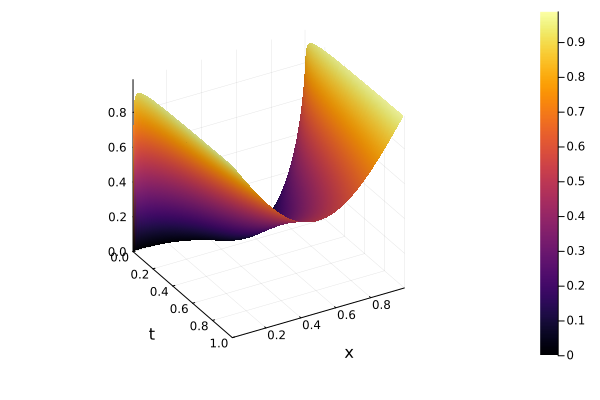

In [9]:
plot(surface(heat1d.t,heat1d.x,Uf[1],camera=(60,30),xlabel="t",ylabel="x"))

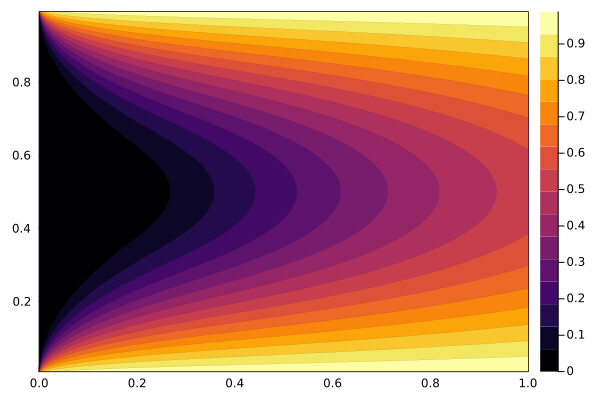

In [10]:
plot(contourf(heat1d.t,heat1d.x,Uf[1],lw=0))

From the 3d plot above we can see that the Crank-Nicolson scheme does not perform very well at the boundaries of the system. Thus, we will just use the normal backward Euler scheme.

## Backward Euler Method

Contrast to the forward Euler approach, the backward Euler approach evaluates the unknown approximation on both sides of the equation which reduces the order of error but makes the algebraic computation more complicated.

$$
\begin{gather}
\frac{u^{k+1}_j - u^k_j}{\Delta t}  =  \mu\frac{u^{k+1}_{j+1} - 2u^{k+1}_j + u^{k+1}_{j-1}}{\Delta x^2} \\
\dot{\vec{u}}^{k+1} = A\vec{u}^{k+1}
\end{gather}
$$

where 

$$
\begin{gather}
A = \frac{\mu}{\Delta x^2} \begin{bmatrix}
-2 & 1 & 0 & 0 & 0 & \cdots & 0 \\
1 & -2 & 1 & 0 & 0 & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & 0 \\
0 & 0 & 1 & -2 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & 0 & 0 & \cdots & -2
\end{bmatrix}
\end{gather}
$$

For the initial and last states we can see that $(j-1)$-th and $(j+1)$-th are missing respectively. Thus, we compliment these using the boundary conditions. The boundary conditions can be incorporated by

$$
\begin{gather}
B = \frac{\mu}{\Delta x^2}\begin{bmatrix}
u_0^k \\ 0 \\ \vdots \\ 0 \\ u_{J+1}^k
\end{bmatrix}
\end{gather}
$$

Then we have

$$
\begin{gather}
\frac{\vec{u}^{k+1} - \vec{u}^k}{\Delta t} = A\vec{u}^{k+1} + B \\
\vec{u}^{k+1} = (I - \Delta t A)^{-1}(\vec{u}^k + \Delta t B).
\end{gather}
$$

In [2]:
provide_R = false

# 1D Heat equation setup
heat1d = Heat1D(
    [0.0, 1.0], [0.0, 1.0], [0.1, 10],
    2^(-7), 1e-3, 10
)
heat1d.x = heat1d.x[2:end-1]

# Some options for operator inference
options = LnL.LS_options(
    system=LnL.sys_struct(
        is_lin=true,
        has_control=true,
        has_output=true,
    ),
    vars=LnL.vars(
        N=1,
    ),
    data=LnL.data(
        Δt=1e-3,
        deriv_type="BE"
    ),
    optim=LnL.opt_settings(
        verbose=true,
    ),
)

Xfull = Vector{Matrix{Float64}}(undef, heat1d.Pdim)
Yfull = Vector{Matrix{Float64}}(undef, heat1d.Pdim)
pod_bases = Vector{Matrix{Float64}}(undef, heat1d.Pdim)

A_intru = Vector{Matrix{Float64}}(undef, heat1d.Pdim)
B_intru = Vector{Matrix{Float64}}(undef, heat1d.Pdim)
C_intru = Vector{Matrix{Float64}}(undef, heat1d.Pdim)

A_opinf = Vector{Matrix{Float64}}(undef, heat1d.Pdim)
B_opinf = Vector{Matrix{Float64}}(undef, heat1d.Pdim)
C_opinf = Vector{Matrix{Float64}}(undef, heat1d.Pdim)

r = 15  # order of the reduced form

@info "Generate intrusive and inferred operators"
p = Progress(length(heat1d.μs))
for (idx, μ) in enumerate(heat1d.μs)
    A, B = heat1d.generateABmatrix(heat1d.Xdim, μ, heat1d.Δx)
    C = ones(1, heat1d.Xdim) / heat1d.Xdim

    op_heat = LnL.operators(A=A, B=B, C=C)

    # Compute the states with backward Euler
    X = LnL.backwardEuler(A, B, heat1d.Ubc, heat1d.t, heat1d.IC)
    Xfull[idx] = X

    # Compute the SVD for the POD basis
    F = svd(X)
    Vr = F.U[:, 1:r]
    pod_bases[idx] = Vr

    # Compute the output of the system
    Y = C * X
    Yfull[idx] = Y

    # Compute the values for the intrusive model
    op_heat_new = LnL.intrusiveMR(op_heat, Vr, options)
    A_intru[idx] = op_heat_new.A
    B_intru[idx] = op_heat_new.B
    C_intru[idx] = op_heat_new.C

    # Compute the RHS for the operator inference based on the intrusive operators
    if provide_R
        jj = 2:heat1d.Tdim
        Xn = X[:, jj]
        Un = heat1d.Ubc[jj, :]
        Yn = Y[:, jj]
        Xdot = A_intru[idx] * Vr' * Xn + B_intru[idx] * Un'
        op_infer = LnL.inferOp(Xn, Un, Yn, Vr, Xdot, options)
    else
        op_infer = LnL.inferOp(X, heat1d.Ubc, Y, Vr, options)
    end

    A_opinf[idx] = op_infer.A
    B_opinf[idx] = op_infer.B
    C_opinf[idx] = op_infer.C
    
    next!(p)
end

┌ Info: Generate intrusive and inferred operators
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\01_heat1D_OpInf_LS.ipynb:45


Progress:  20%|█████████                                |  ETA: 0:01:08

Progress:  30%|█████████████                            |  ETA: 0:00:48

Progress:  40%|█████████████████                        |  ETA: 0:00:35

Progress:  50%|█████████████████████                    |  ETA: 0:00:27

Progress:  60%|█████████████████████████                |  ETA: 0:00:20

Progress:  70%|█████████████████████████████            |  ETA: 0:00:14

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:09

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:04

Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


In [3]:
@info "Compute errors"

# Error analysis 
intru_state_err = zeros(r, 1)
opinf_state_err = zeros(r, 1)
intru_output_err = zeros(r, 1)
opinf_output_err = zeros(r, 1)
proj_err = zeros(r, 1)

@showprogress for i = 1:r, j = 1:heat1d.Pdim
    Xf = Xfull[j]  # full order model states
    Yf = Yfull[j]  # full order model outputs
    Vr = pod_bases[j][:, 1:i]  # basis

    # Unpack intrusive operators
    Aint = A_intru[j]
    Bint = B_intru[j]
    Cint = C_intru[j]

    # Unpack inferred operators
    Ainf = A_opinf[j]
    Binf = B_opinf[j]
    Cinf = C_opinf[j]

    # Integrate the intrusive model
    Xint = LnL.backwardEuler(Aint[1:i, 1:i], Bint[1:i, :], heat1d.Ubc, heat1d.t, Vr' * heat1d.IC)
    Yint = Cint[1:1, 1:i] * Xint

    # Integrate the inferred model
    Xinf = LnL.backwardEuler(Ainf[1:i, 1:i], Binf[1:i, :], heat1d.Ubc, heat1d.t, Vr' * heat1d.IC)
    Yinf = Cinf[1:1, 1:i] * Xinf

    # Compute errors
    PE, ISE, IOE, OSE, OOE = LnL.compError(Xf, Yf, Xint, Yint, Xinf, Yinf, Vr)

    # Sum of error values
    proj_err[i] += PE / heat1d.Pdim
    intru_state_err[i] += ISE / heat1d.Pdim
    intru_output_err[i] += IOE / heat1d.Pdim
    opinf_state_err[i] += OSE / heat1d.Pdim
    opinf_output_err[i] += OOE / heat1d.Pdim
end

┌ Info: Compute errors
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\01_heat1D_OpInf_LS.ipynb:1


Progress:  13%|██████                                   |  ETA: 0:00:02

Progress:  33%|██████████████                           |  ETA: 0:00:01

Progress:  47%|████████████████████                     |  ETA: 0:00:01

Progress:  60%|█████████████████████████                |  ETA: 0:00:00

Progress:  73%|███████████████████████████████          |  ETA: 0:00:00

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:00

Progress:  87%|████████████████████████████████████     |  ETA: 0:00:00

Progress:  93%|███████████████████████████████████████  |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [4]:
df = DataFrame(
order=1:r,
projection_err=vec(proj_err),
intrusive_state_err=vec(intru_state_err),
intrusive_output_err=vec(intru_output_err),
inferred_state_err=vec(opinf_state_err),
inferred_output_err=vec(opinf_output_err)
)
df

15×6 DataFrame
 Row │ order  projection_err  intrusive_state_err  intrusive_output_err  infer ⋯
     │ Int64  Float64         Float64              Float64               Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1     0.0539518            0.11401               0.107904           ⋯
   2 │     2     0.00952335           0.0145772             0.0039857
   3 │     3     0.002405             0.00335037            0.000442444
   4 │     4     0.000707421          0.000941203           5.33031e-5
   5 │     5     0.000234362          0.000303014           8.56959e-6         ⋯
   6 │     6     8.2872e-5            0.000105091           1.29706e-6
   7 │     7     2.96332e-5           3.70327e-5            1.9115e-7
   8 │     8     1.03601e-5           1.27898e-5            2.53602e-8
   9 │     9     3.48089e-6           4.25064e-6            3.07889e-9         ⋯
  10 │    10     1.11466e-6           1.34744e-6            3.3524e-10
  11 │    11     3.38766e-7           4.05601e-7            3.28508e-11
  12 │    12     9.74796e-8           1.15646e-7            2.88772e-12
  13 │    13     2.65131e-8           3.11787e-8            2.38147e-13        ⋯
  14 │    14     6.80688e-9           7.93726e-9            2.91966e-14
  15 │    15     1.6476e-9            1.90564e-9            1.48673e-14
                                                               2 columns omitted

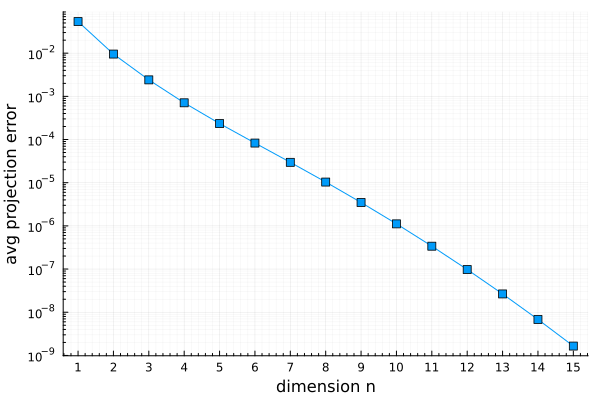

In [5]:
plot(1:r, df.projection_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
yticks!([round(10.0^i,digits=-i) for i in -10:0])
xticks!(1:r)
xlabel!("dimension n")
ylabel!("avg projection error")

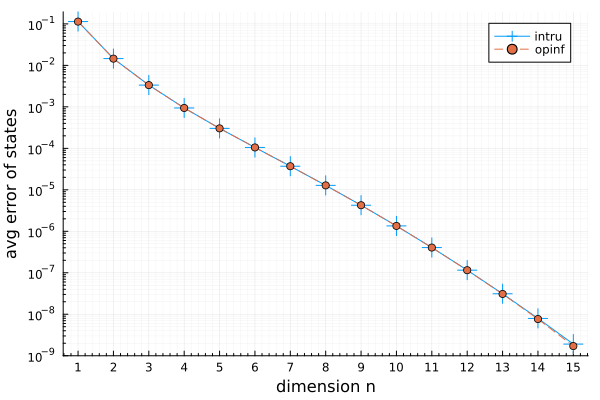

In [6]:
plot(1:r, df.intrusive_state_err, marker=(:cross,10), label="intru")
plot!(1:r, df.inferred_state_err, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true)
yticks!([round(10.0^i,digits=-i) for i in -10:0])
xticks!(1:r)
xlabel!("dimension n")
ylabel!("avg error of states")

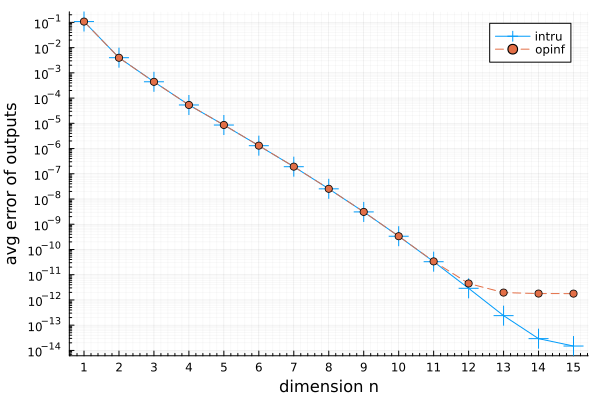

In [7]:
plot(1:r, df.intrusive_output_err, marker=(:cross,10), label="intru")
plot!(1:r, df.inferred_output_err, marker=(:circle), ls=:dash, label="opinf")
plot!(yscale=:log10, majorgrid=true, minorgrid=true)
yticks!([round(10.0^i,digits=-i) for i in -15:0])
xticks!(1:r)
xlabel!("dimension n")
ylabel!("avg error of outputs")